# Income Predictor
This project is all abou learning python and machine learing. These are my first steps and I user several sources.
I will try to train a classifier to predict if the income is over 50K or under 50K.<

## Libraries
First we will import some libraries we will use

In [34]:
# Working with data
import numpy as np
import pandas as pd 

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore');

## Importing the Dataset


In [2]:
dataset = pd.read_csv('adult.csv')
dataset.columns = ['Age', 'Work Class', 'Final Weight', 'Education', 'Education Number', 'Marital Status', 'Occupation',
          'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per Week', 'Country', 'Income']


Conver target column into numerical classes. This will convert under 50K into a 0 and over 50K into a 1. Therefore it will be easier to workt with.

In [3]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
dataset['Income'] = labelEncoder.fit_transform(dataset['Income'])

## Data Analysis
First we take an initial look in the data to see how many individuals are in each group.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               32561 non-null  int64 
 1   Work Class        32561 non-null  object
 2   Final Weight      32561 non-null  int64 
 3   Education         32561 non-null  object
 4   Education Number  32561 non-null  int64 
 5   Marital Status    32561 non-null  object
 6   Occupation        32561 non-null  object
 7   Relationship      32561 non-null  object
 8   Race              32561 non-null  object
 9   Sex               32561 non-null  object
 10  Capital Gain      32561 non-null  int64 
 11  Capital Loss      32561 non-null  int64 
 12  Hours per Week    32561 non-null  int64 
 13  Country           32561 non-null  object
 14  Income            32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


The output above shows that there is no missing data in the dataset.

## Data Preprocessing
The data must be processed in order to be used for machine learing.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cec6310>,
      dtype=object)

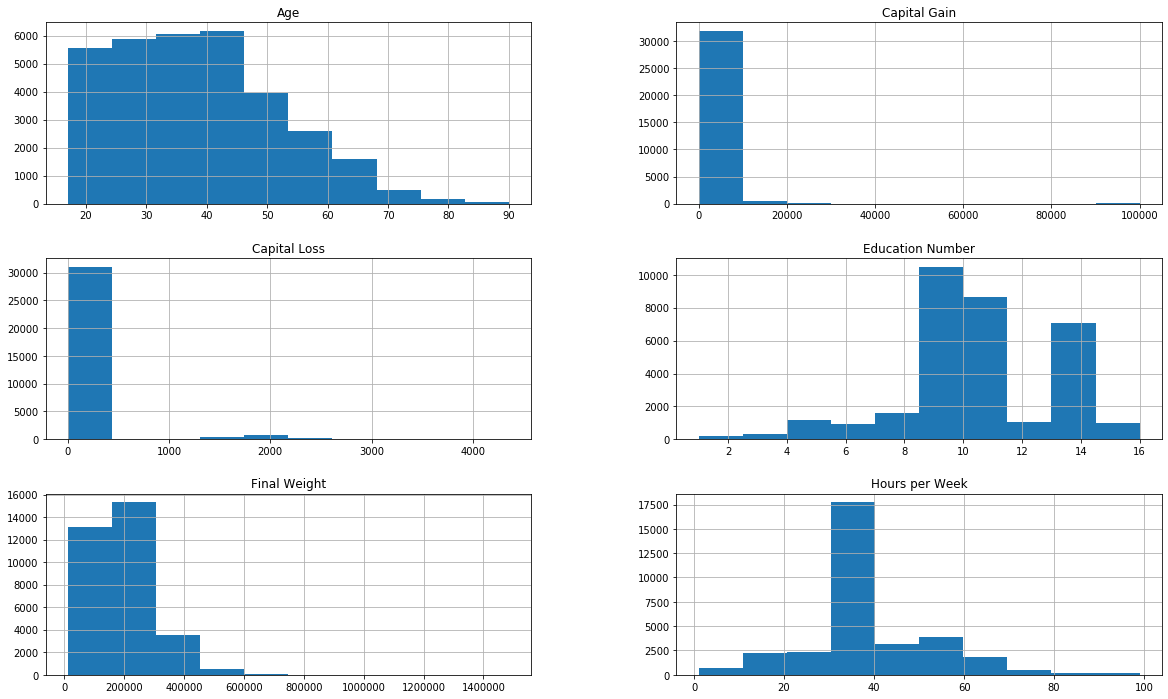

In [5]:
rcParams['figure.figsize'] = 20, 12
#[] will extract data as a series [[]] will extract the data as a DataFrame
dataset[['Age', 'Final Weight', 'Education Number', 'Capital Gain', 'Capital Loss', 'Hours per Week']].hist()

1. Capital Gain and Captial Loss are left skewed wich means that the mean is less than the median of the data.
2. Final Weight is also left skewed

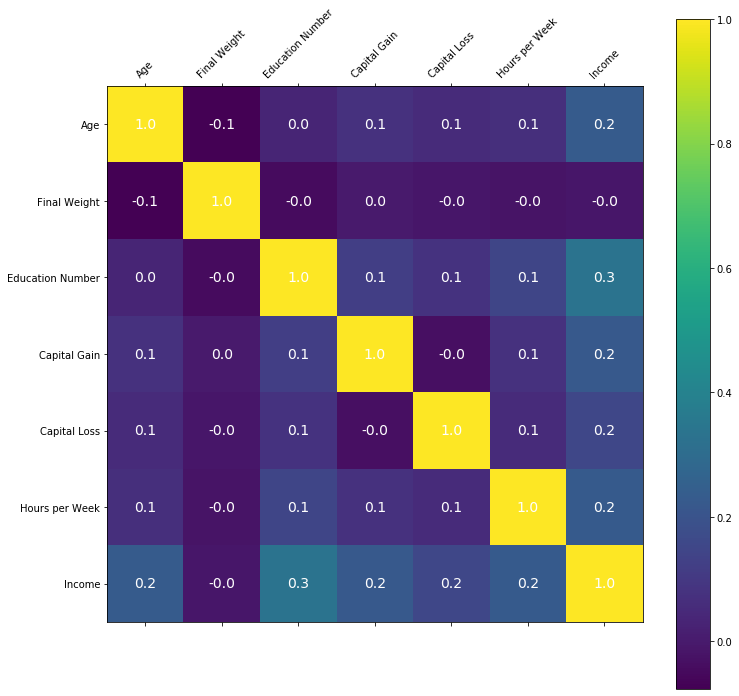

In [6]:
# plots
plt.matshow(dataset.corr())
plt.colorbar()

# labeling
plt.xticks(np.arange(len(dataset.corr().columns)), 
           dataset.corr().columns.values, 
           rotation = 45) 
plt.yticks(np.arange(len(dataset.corr().columns)), 
           dataset.corr().columns.values) 
for (i, j), corr in np.ndenumerate(dataset.corr()):
    plt.text(j, i, '{:0.1f}'.format(corr), ha='center', va='center', color='white', fontsize=14)

When you take a look at the correlation matrix you can see that there is no high linear correlation between features. Also`Final Weight` correlates`-0.0` with `Income`, which makes no sense so it's better to drop this column.

### Age
Now I will sperate the age into bins:
1. 0 - 25: Young
2. 25 - 50: Adult
3. 50 - 100: Old

You can take smaller and more precise bins, but for conveniece I decided to go with this.

In [7]:
dataset['Age'] = pd.cut(dataset['Age'], 
                        bins = [0,25,50,100], 
                        labels = ['Young', 'Adult', 'Old'])

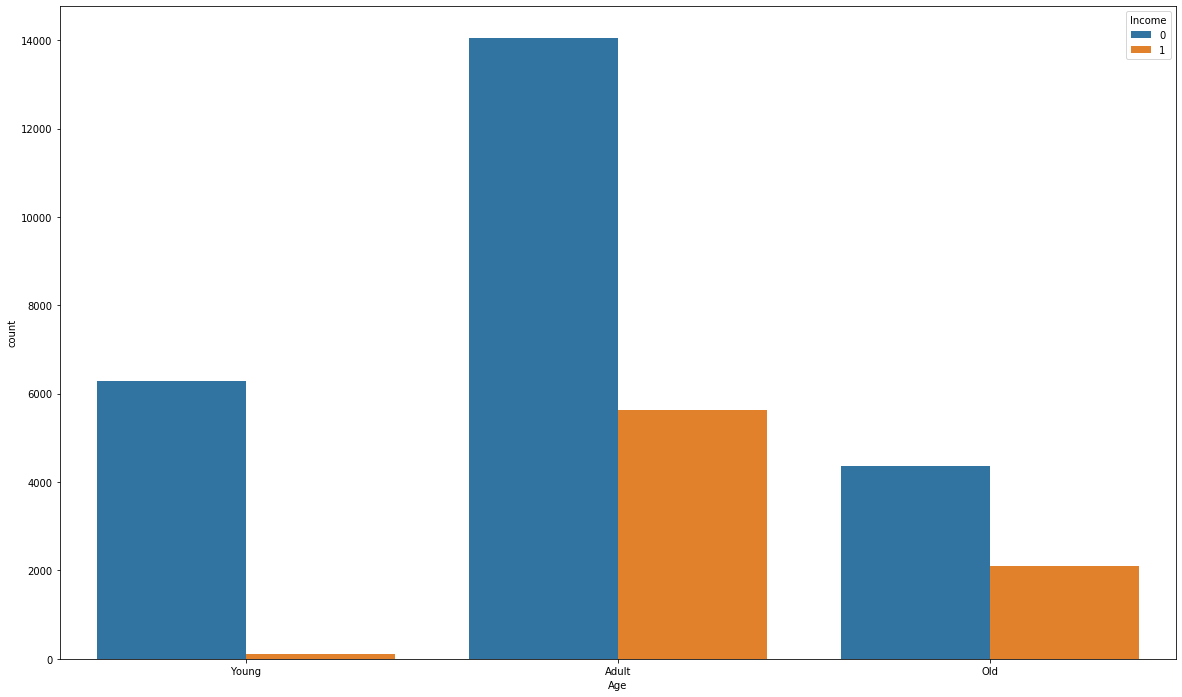

In [8]:
sns.countplot(x = 'Age', hue = 'Income', data = dataset)

### Capital Gain and Capital Loss

In [9]:
# If Capital Diff is positive the person is making passive income
dataset['Capital Diff'] = dataset['Capital Gain'] - dataset['Capital Loss']

dataset.drop(['Capital Gain'], axis = 1, inplace = True)
dataset.drop(['Capital Loss'], axis = 1, inplace = True)

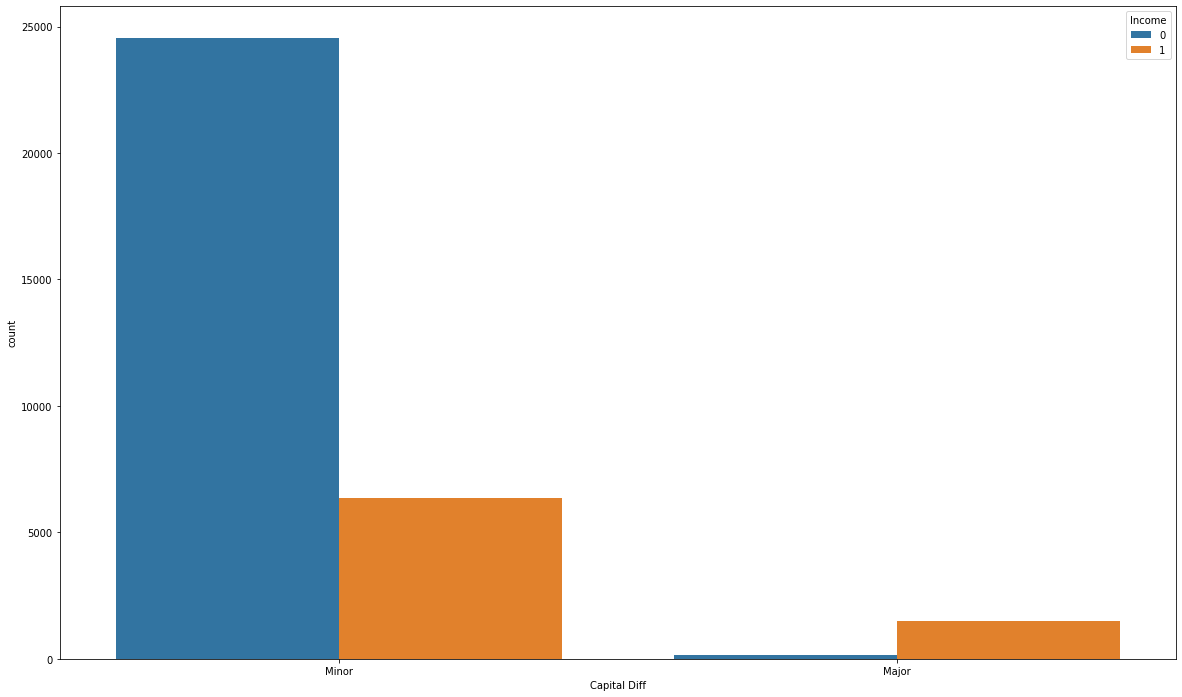

In [10]:
# Binning the Capital Diff in Minor and Major
dataset['Capital Diff'] = pd.cut(dataset['Capital Diff'], 
                                 bins = [-5000, 5000, 100000], 
                                 labels = ['Minor', 'Major'])

sns.countplot(x = 'Capital Diff', hue = 'Income', data = dataset)

You can see that people with a `Minor Captial Diff` (low captial gain; high capital loss) are more likely to have an income under 50K.
People with a `Major Captial Diff` (high captial gain; low capital loss) are more likely to have an income over 50K. This is totally logical and can help us later.

### Final Weight
As we can see in the correlation matrix, there is no correlation between `Final Weight` and `Income`. Therefore we can drop this column.

In [11]:
dataset.drop(['Final Weight'], 
             axis = 1, 
             inplace = True)

### Hours per Week
If we take a look at the `Hours per Week` Histogram we can see that there is a major spike around 30-40h because these are the usual Hours to be expected.

In [12]:
dataset['Hours per Week'] = pd.cut(dataset['Hours per Week'], 
                                   bins = [0, 30, 40, 100], 
                                   labels = ['Lesser Hours', 'Normal Hours', 'Extra Hours'])

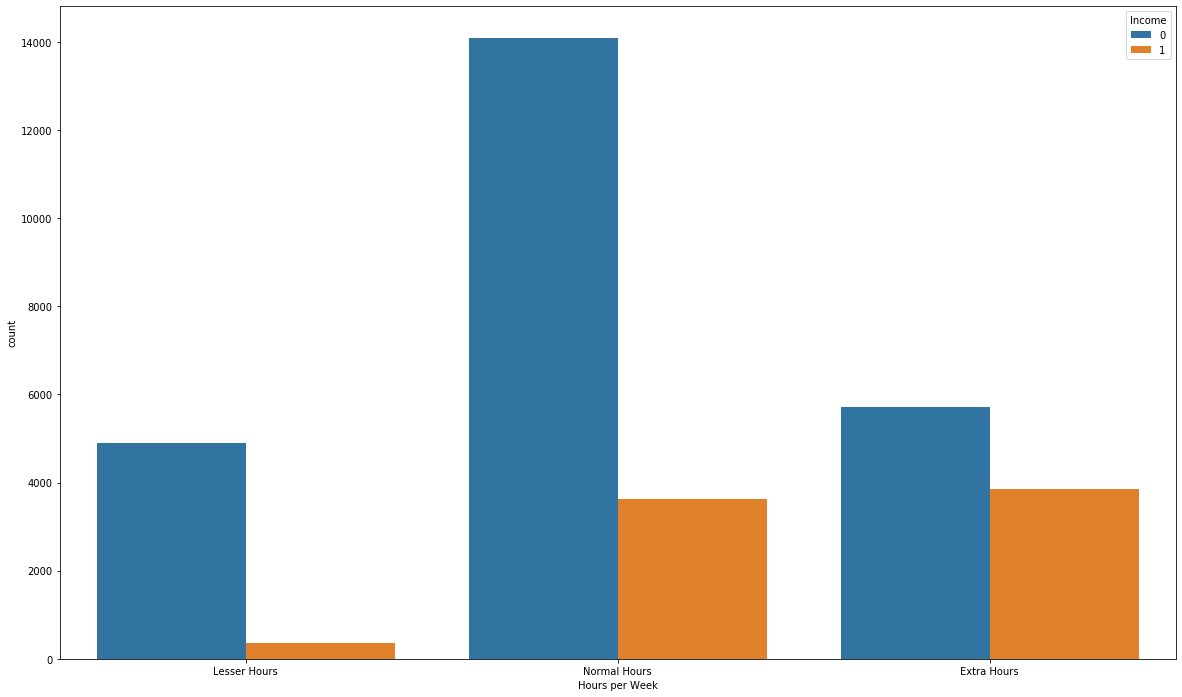

In [13]:
sns.countplot(x = 'Hours per Week', hue = 'Income', data = dataset)

### Work class

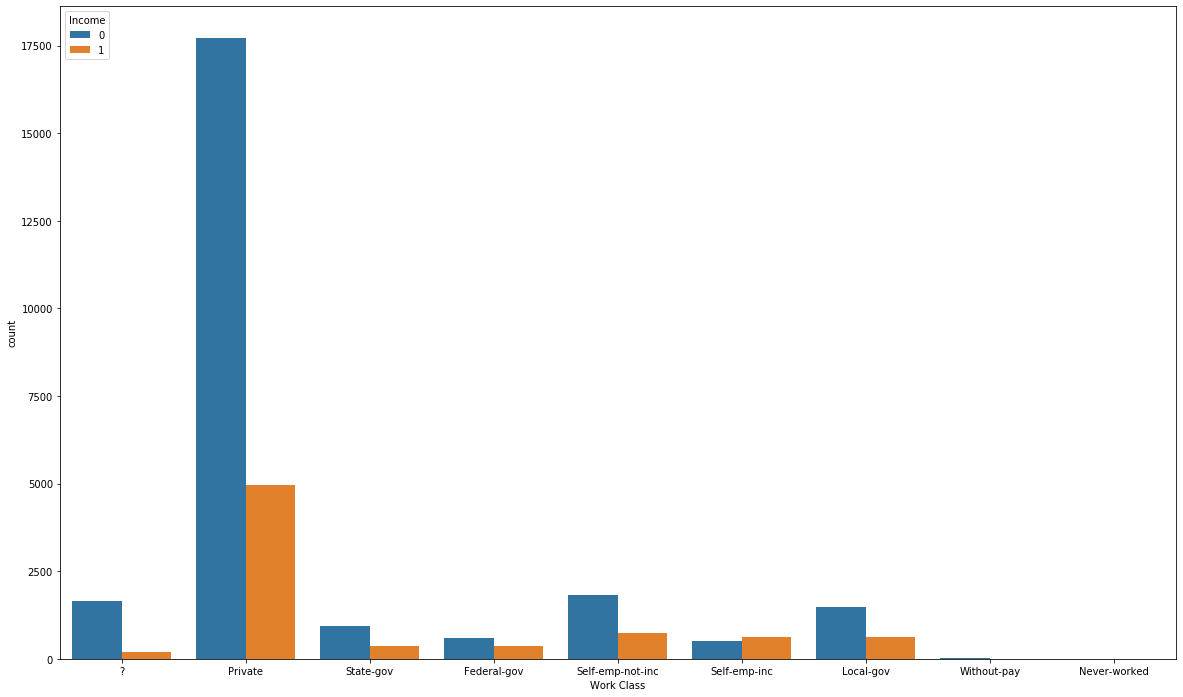

In [14]:
sns.countplot(x = 'Work Class', hue = 'Income', data = dataset)

In [15]:
dataset = dataset.drop(dataset[dataset['Work Class'] == '?'].index)
dataset = dataset.drop(dataset[dataset['Work Class'] == 'Without-pay'].index)
dataset = dataset.drop(dataset[dataset['Work Class'] == 'Never-worked'].index)

### Education and Education Number
It's a good time to check if there is any relation between Education and Education Number.

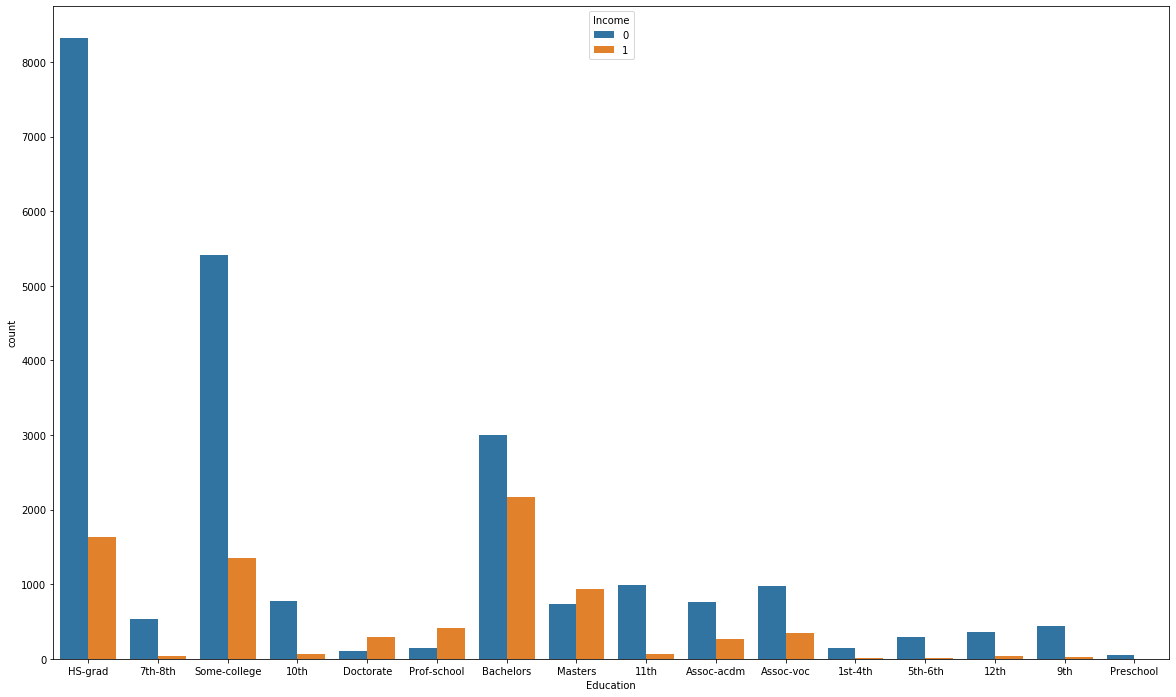

In [16]:
sns.countplot(x = 'Education', hue = 'Income', data = dataset)

In [17]:
education_classes = dataset['Education'].unique()
for edu_class in education_classes:
    print("For {}, the Education Number is {}"
          .format(edu_class, dataset[dataset['Education'] == edu_class]['Education Number'].unique()))

For HS-grad, the Education Number is [9]
For 7th-8th, the Education Number is [4]
For Some-college, the Education Number is [10]
For 10th, the Education Number is [6]
For Doctorate, the Education Number is [16]
For Prof-school, the Education Number is [15]
For Bachelors, the Education Number is [13]
For Masters, the Education Number is [14]
For 11th, the Education Number is [7]
For Assoc-acdm, the Education Number is [12]
For Assoc-voc, the Education Number is [11]
For 1st-4th, the Education Number is [2]
For 5th-6th, the Education Number is [3]
For 12th, the Education Number is [8]
For 9th, the Education Number is [5]
For Preschool, the Education Number is [1]


In [18]:
dataset.drop(['Education Number'], axis = 1, inplace = True)
dataset['Education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'],
                             'School', inplace = True)
dataset['Education'].value_counts()

HS-grad         9959
Some-college    6772
Bachelors       5182
School          3820
Masters         1675
Assoc-voc       1321
Assoc-acdm      1019
Prof-school      558
Doctorate        398
Name: Education, dtype: int64

### Marital Status and Relationship

In [19]:
dataset['Marital Status'].value_counts()

Married-civ-spouse       14331
Never-married             9908
Divorced                  4258
Separated                  959
Widowed                    839
Married-spouse-absent      388
Married-AF-spouse           21
Name: Marital Status, dtype: int64

In [20]:
dataset['Relationship'].value_counts()

Husband           12700
Not-in-family      7865
Own-child          4520
Unmarried          3269
Wife               1432
Other-relative      918
Name: Relationship, dtype: int64

### Occupation

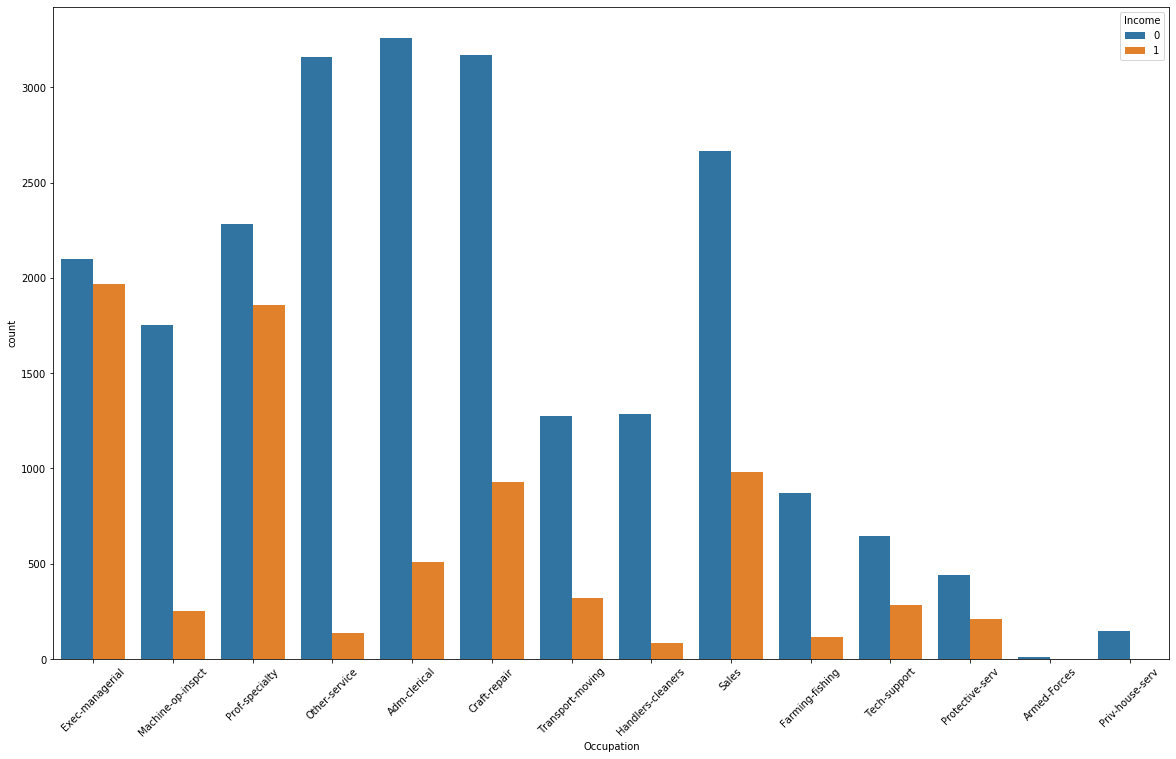

In [21]:
plt.xticks(rotation = 45)
sns.countplot(x = 'Occupation', hue = 'Income', data = dataset)

### Race

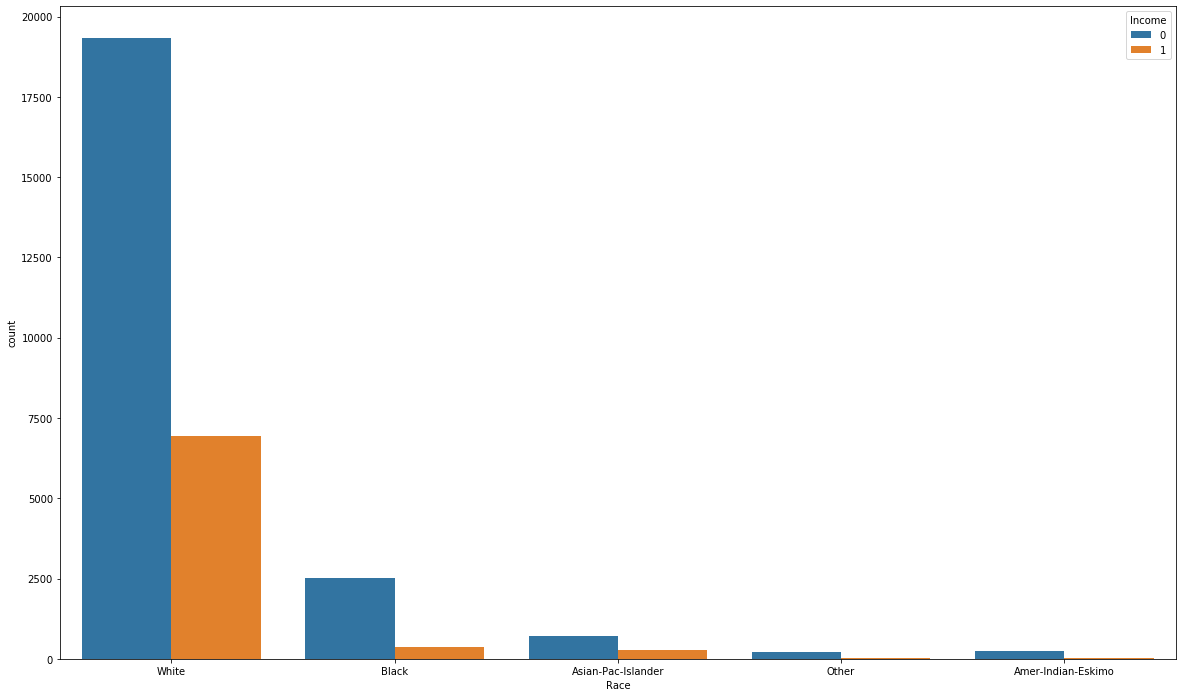

In [22]:
sns.countplot(x = 'Race', hue = 'Income', data = dataset)

The dataset mainly contains data about white people, so I'll combine the other races into one group.

In [23]:
dataset['Race'].unique()
dataset['Race'].replace([' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other'],' Other', inplace = True)

### Sex

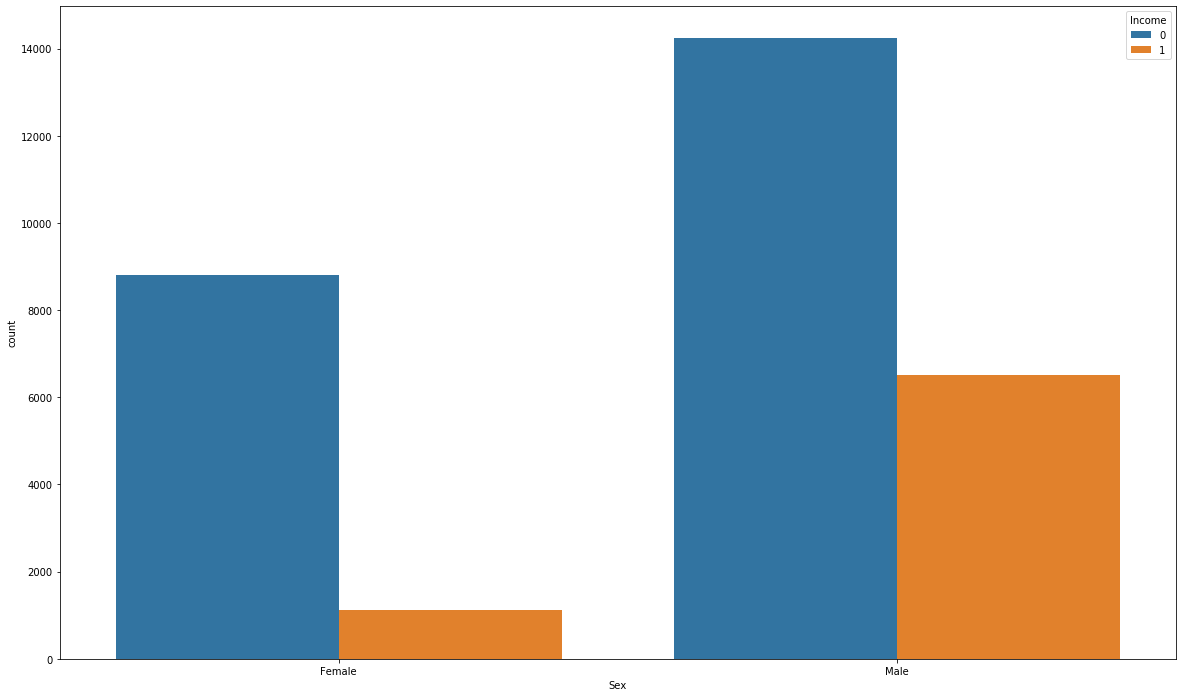

In [24]:
sns.countplot(x = 'Sex', hue = 'Income', data = dataset)

Although there are is more data about men, you can see that there is a higher percentage of Men who have an income over 50K compared to women.

### Country

In [25]:
country_count = dataset['Country'].value_counts()
country_count

United-States                 27491
Mexico                          610
?                               556
Philippines                     187
Germany                         128
Puerto-Rico                     109
Canada                          107
El-Salvador                     100
India                           100
Cuba                             92
England                          86
Jamaica                          80
South                            71
China                            68
Italy                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        63
Japan                            59
Columbia                         56
Poland                           56
Taiwan                           42
Haiti                            42
Iran                             42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                      

Text(0.5, 1.0, 'Total adults from each Country')

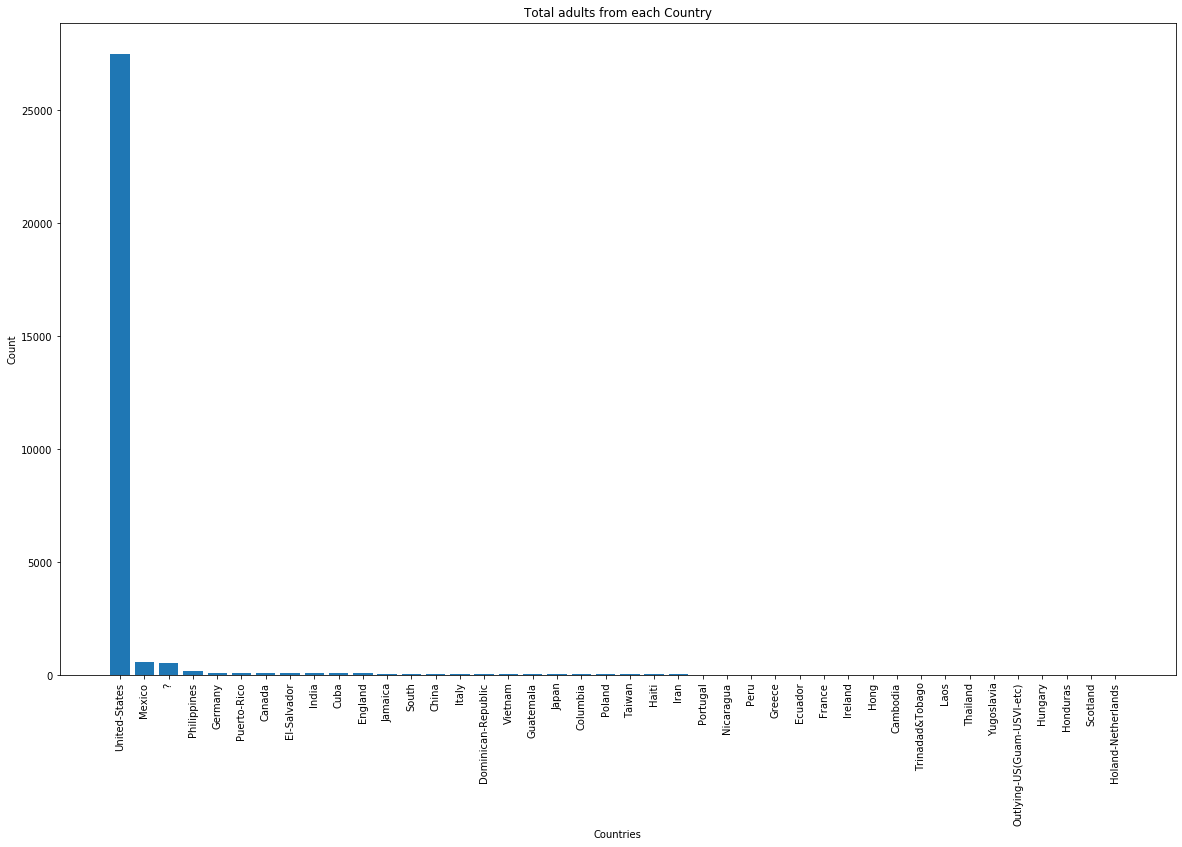

In [26]:
plt.bar(country_count.index, country_count.values)
plt.xticks(rotation = 90)
plt.xlabel('Countries')
plt.ylabel('Count')
plt.title('Total adults from each Country')

Removing '?' and combining states excpet US to 'Other'.

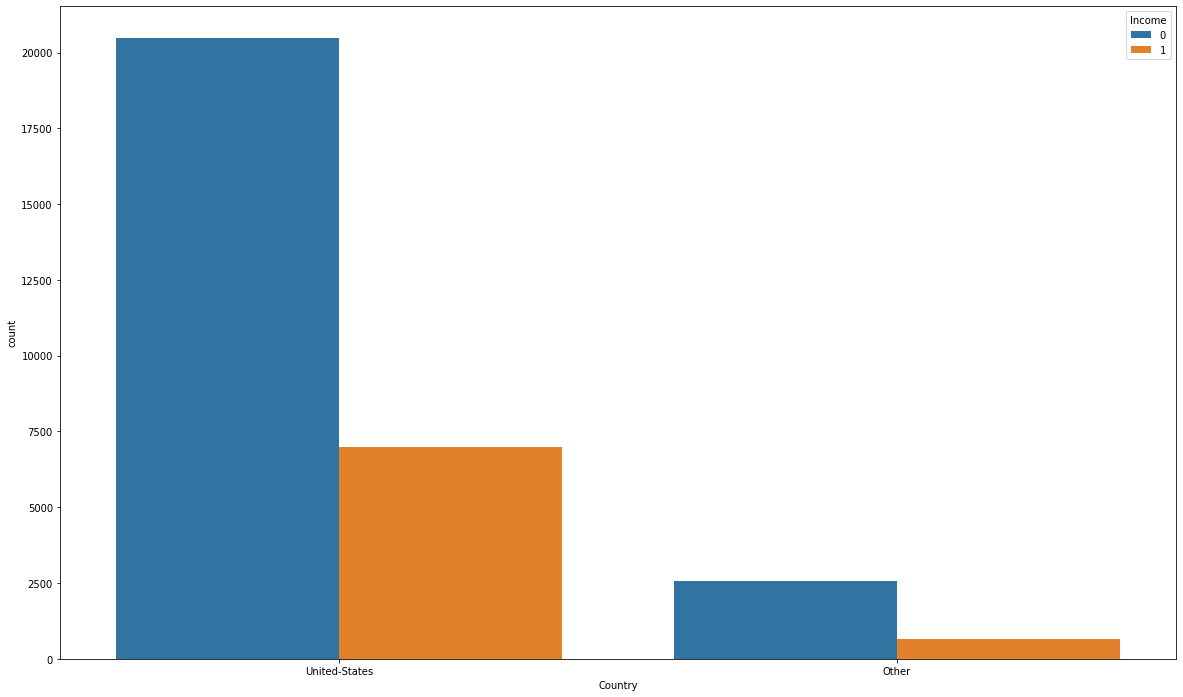

In [27]:
dataset = dataset.drop(dataset[dataset['Country'] == ' ?'].index)

countries = np.array(dataset['Country'].unique())
countries = np.delete(countries, 0)

dataset['Country'].replace(countries, 'Other', inplace = True)

sns.countplot(x = 'Country', hue = 'Income', data = dataset)

### Data manipulation

I will use the get_dummies method of pandas to get separate columns for each feature based on the unqiue values in the dataset.

In [28]:
y = dataset['Income']
X = dataset.drop(['Income'], axis = 1)
X = pd.get_dummies(X)
print("Total features: {}".format(X.shape[1]))

Total features: 59


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

## Machine Learning

In [30]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [31]:
classifiers = [GaussianNB(), 
               SVC(kernel = 'rbf', probability = True), 
               DecisionTreeClassifier(random_state = 0), 
               RandomForestClassifier(n_estimators = 100, random_state = 0), 
               GradientBoostingClassifier(random_state = 0)]
classifier_names = ["Gaussian Naive Bayes", 
                    "Support Vector Classifier", 
                    "Decision Tree Classifier", 
                    "Random Forest Classifier", 
                    "Gradient Boosting Classifier"]
accuracies = []

In [32]:
for i in range(len(classifiers)):
    classifier = classifiers[i]
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print("{}:".format(classifier_names[i]))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    accuracy = accuracy_score(y_test, y_pred)*100
    accuracies.append(accuracy)

Gaussian Naive Bayes:
F1 score: 0.64
Support Vector Classifier:
F1 score: 0.65
Decision Tree Classifier:
F1 score: 0.61
Random Forest Classifier:
F1 score: 0.65
Gradient Boosting Classifier:
F1 score: 0.66


## Analysing Results
### Accuracy Plots

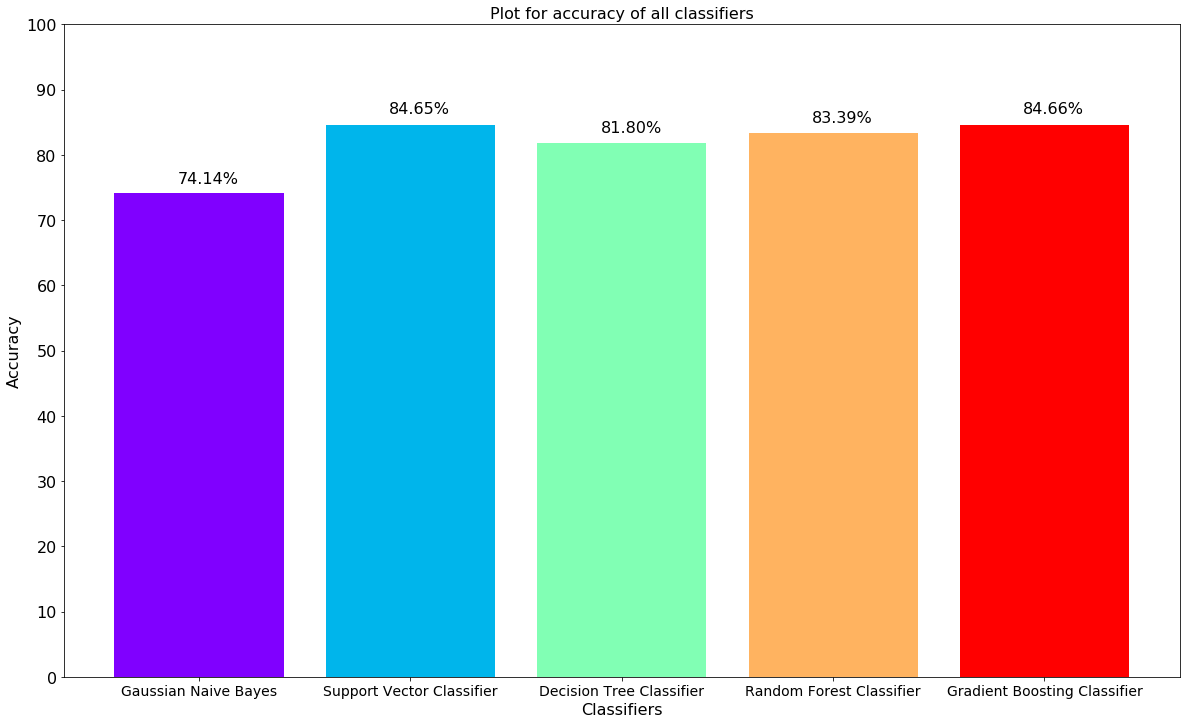

In [33]:
from matplotlib.cm import rainbow

plt.figure(figsize = (20, 12))
colors = rainbow(np.linspace(0, 1, len(classifiers)))
barplot = plt.bar(classifier_names, accuracies, color = colors)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize = 16)
plt.xticks(fontsize = 14)
plt.xlabel("Classifiers", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.title("Plot for accuracy of all classifiers", fontsize = 16)
for i, bar in enumerate(barplot):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, 
             bar.get_height()*1.02, 
             s = '{:.2f}%'.format(accuracies[i]), 
             fontsize = 16)

### ROC

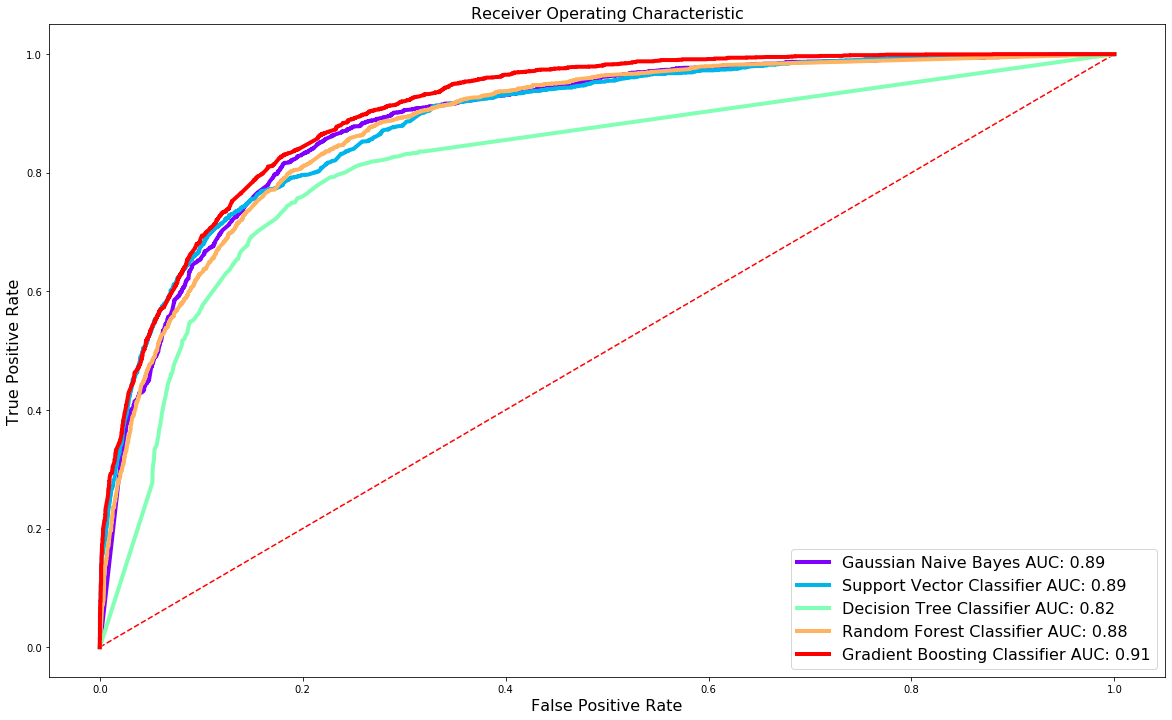

In [35]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

for i in range(len(classifiers)):
    classifier = classifiers[i]
    probs = classifier.predict_proba(X_test)
    # Reading probability of second class
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    label = classifier_names[i] + ' AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = colors[i], label = label, linewidth = 4)
    
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)